# Spectrum Sensing (Sparsity)

## Looking Ahead

In this series of examples, we are going to explore the use of compressive sensing for spectrum sensing in a simulated frequency-multiplexed channel sharing scheme. This first notebook will facilitate our exploration of the spectral content of simulated data from such a scheme, and expose the underlying sparsity of the frequency spectrum, which will make compressive sensing techniques applicable in later notebooks.

The precise nature of the model frequency-multiplexed transmission scheme is described in the homework. Here, we will load the simulated data from a file, remind ourselves of some points germane to working with RF signals, and then finally examine the frequency sparsity of the data.

## Downloading the Data

We download the data file from the Github page. The file is `ss_signal.mat`.

In [1]:
!git clone https://github.com/hwagyesa/ss_data.git

Cloning into 'ss_data'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), done.


## Loading and Understanding the Data

Next, we load the signal and the provided parameters into memory, and look at the available keys.

In [2]:
import scipy.io as sio
import numpy as np
import bokeh.plotting as bpl
import pprint

D = sio.loadmat('/content/ss_data/ss_signal.mat', squeeze_me=True)
D_short = {k: v for k, v in D.items() if not k.startswith('_')}
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(D_short)

{   'B': 100000,
    'Nslots': 16,
    'Nuser': 256,
    'SNR': 30,
    'fmin': 600000,
    'fs': 52400000,
    'slot_time': 0.001,
    'x': array([-9.35155660e-05,  5.30138293e-05,  2.55137439e-05, ...,
       -3.70700023e-03, -5.00412343e-03, -1.00440859e-03])}


Here is a description of the contained parameters:
- `x`: The frequency-multiplexed channel's voltage signal. All subsequent parameters relate to different aspects of this signal.
- `SNR`: The signal-to-noise ratio of `x`, measured in decibels. Here we again emphasize that `x` is a voltage signal, and that we have added i.i.d. Gaussian random variables to each sample bin to ensure the specified SNR is met.
- `fmin`: The minimum frequency in the channel's allocated frequency band, measured in Hz.
- `B`: The bandwidth of a single user's subband allocation (in frequency), measured in Hz. 
- `Nuser`: The number of users, or subbands, in the allocated frequency range. We have the relation `fmax - fmin = Nuser * B`, so we can derive the maximum band frequency `fmax` from the previous three parameters.
- `fs`: The sampling frequency of the signal `x`, in Hz. Here we have used Nyquist-rate sampling, so `fs = 2 * fmax`.
- `Nslots`: This is a time-transmission parameter, which tells us how many subsequent transmission slots the signal contains.
- `slot_time`: Another time parameter that tells us the duration of a single transmission slot, measured in seconds. The total number of samples in `x` is thus equal to `fs * slot_time * Nslots`, and the total time duration of the signal is `slot_time * Nslots`.

Interpreting given the values above, we see that (for example) the slot bandwidth of our system is 100 kHz and the slot time is 1 ms, among other things.

### Derived Parameters

We compute some of the derived parameters mentioned above in the code block below.


In [0]:
## Move dictionary vars into locals
B = D['B']
Nslots = D['Nslots']
Nuser = D['Nuser']
SNR = D['SNR']
fmin = D['fmin']
fs = D['fs']
slot_time = D['slot_time']
x = D['x']

## Derived parameters
fmax = Nuser * B + fmin
T = slot_time * Nslots
Nsamp = len(x)
slot_dur = Nsamp // Nslots

## Visualizing the Data

Now that we have specified the meaning of the different signal parameters, we can plot the frequency content of different transmission intervals of `x`. First, we generate frequency and time vectors which have the proper physical interpretation in light of our parameter specifications above.

In particular, our signal is sampled at the Nyquist rate, and so its (unrealizable) DTFT is `fs`-periodic, with no aliasing. This tells us what units to place on the frequency axis after we FFT the signal `x`. The time axis is similarly straightforward to determine.



In [0]:
## Time and frequency axes
f_axis = fs * np.arange(-Nsamp/2+1, Nsamp/2+1)/Nsamp
t_axis = Nslots * slot_time * np.arange(0, Nsamp)/Nsamp
f_axis = np.squeeze(f_axis)
t_axis = np.squeeze(t_axis)

In [5]:
## Plot the time signal, over a single slot time
bpl.output_notebook()
h = bpl.figure(title="Time-domain signal x")
h.xaxis.axis_label = 'Time (ms)'
h.yaxis.axis_label = 'Voltage (V)'
h.line(t_axis[0:slot_dur]*1.0e3, x[0:slot_dur])
bpl.show(h)

This plot does not tell us much about the characteristics of the signal `x`, which is of course more naturally viewed in the frequency domain. We plot this next.

**Note**: We use some tricks with the Fourier transform below, which you should make sure you understand. *First*, we use `fftshift` after calling `fft`: this is because the returned signal from `fft` represents the frequency content in the interval `[0, fs]`, whereas we are more used to having a DC-centered view of the frequency content, from `[-fs/2, fs/2]`. `fftshift` performs this adjustment by shuffling the array. *Second*, we also downsample the `f_axis` variable: this is because when we look at the frequency content in the first transmission slot, we have a shorter time duration to work with, so although the overall frequency band that we view is the same (we did not change the sampling frequency!), the frequency resolution becomes worse.

In [6]:
slot1_x = x[0:slot_dur]
slot1_X = np.fft.fftshift(np.fft.fft(slot1_x))
## We need to downsample the frequency axis to match the shorter slot time
slot_f_axis = f_axis[::Nslots]

## Make the plot
bpl.output_notebook()
h = bpl.figure(title="Frequency-domain signal x, during first slot")
h.xaxis.axis_label = 'Frequency (MHz)'
h.yaxis.axis_label = 'Power (dB)'
h.line(slot_f_axis * 1e-6, 20 * np.log10(np.absolute(slot1_X)))
bpl.show(h)


We see that the signal consists of just a few different transmitters during the first transmission slot. We can get a closer view by plotting just our frequency band of interest, over the positive frequency axis.

In [7]:
inband_mask = np.where((slot_f_axis >= fmin) & (slot_f_axis <= fmax))[0]

bpl.output_notebook()
h = bpl.figure(title="Frequency-domain signal x, during first slot (positive band-of-interest)")
h.xaxis.axis_label = 'Frequency (MHz)'
h.yaxis.axis_label = 'Power (dB)'
h.line(slot_f_axis[inband_mask] * 1e-6,
       20 * np.log10(np.absolute(slot1_X[inband_mask])))
bpl.show(h)

## Your Tasks

Each level three header below contains a task you should complete. See the homework handout for additional details.

### Task 1: Viewing Frequency Domain Signal In a Particular Subband

Now let's get an idea of which users are transmitting by zooming into a single subband, given our knowledge of the transmit scheme parameters. We know that the bands have bandwidth `B`, and that the frequency interval `[fmin, fmax]` is divided up into `Nuser` of them. From here we can compute the center frequency for each of the `Nuser` bands in the interval, and view their content by looking `B/2` above and below. 

1. Find out the center frequency of the 216th subband, and plot the frequency domain signal during the first slot of this subband. This should be a band with width `B`. 

2. Now plot a band with the same center, but with width `8B` (`[center - 4B, center + 4B]`). 

Your **output** should be two figures, showing the power of the frequency domain signal of the band we are interested. 

In [8]:
center_f = fmin + 216 * B - B / 2
subband_mask = np.where((slot_f_axis >= center_f - B/2) & (slot_f_axis <= center_f + B/2))[0]

bpl.output_notebook()
h = bpl.figure(title="Frequency-domain signal x, during first slot (216th subband with width B)")
h.xaxis.axis_label = 'Frequency (MHz)'
h.yaxis.axis_label = 'Power (dB)'
h.line(slot_f_axis[subband_mask] * 1e-6,
       20 * np.log10(np.absolute(slot1_X[subband_mask])))
bpl.show(h)

center_f = fmin + 216 * B - B / 2
subband_mask = np.where((slot_f_axis >= center_f - 4 * B) & (slot_f_axis <= center_f + 4 * B))[0]

bpl.output_notebook()
h = bpl.figure(title="Frequency-domain signal x, during first slot (216th subband with width 8B)")
h.xaxis.axis_label = 'Frequency (MHz)'
h.yaxis.axis_label = 'Power (dB)'
h.line(slot_f_axis[subband_mask] * 1e-6,
       20 * np.log10(np.absolute(slot1_X[subband_mask])))
bpl.show(h)

### Task 2: Evaluating Subband Occupancy Over Time

The goal of this task is to generate a discrete analog of the time signal `x` that allows us to assess the subband-level sparsity of `x` during each time slot. Perform the following tasks:
1. Given the frequency content of a single time slot of `x`, write code to output a vector with `Nuser` entries: the `i`-th entry is 1 if the corresponding subband is occupied during this time slot and 0 otherwise. For example, you can expect as input the fft of a single time slot as we generated for the first timeslot in one of the cells above.
2. Apply the code you wrote in the previous step to estimate the length-`Nuser` vector of subband occupancies for each of the `Nslots` time slots contained in the signal `x`.
3. Visualize the matrix you get to intuitively understand how does users occupy subbands over time. 
4. Plot the density of the signal `x` as a function of the time slot? Here, density means "number of users transmitting simultaneously in a single time slot, divided by total number of users", and can be related to the sparsity of your zero-one matrix from the previous task. How do you interpret this density? 

For this part of the problem, your **output** should be the `Nuser`-by-`Nslots` matrix of subband occupancies for the signal `x`, an image that visualize your matrix, and the figure of density over time. 

**Hint**: You can use the fact that the SNR of the signal `x` is quite high to easily test whether a given subband is occupied or not: index it properly as we have done above (after computing the center frequencies of each subband), and apply something like a simple integrate-and-threshold test.


the Nuser-by-Nslots matrix of subband occupancies for the signal x
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


an image that visualize your matrix


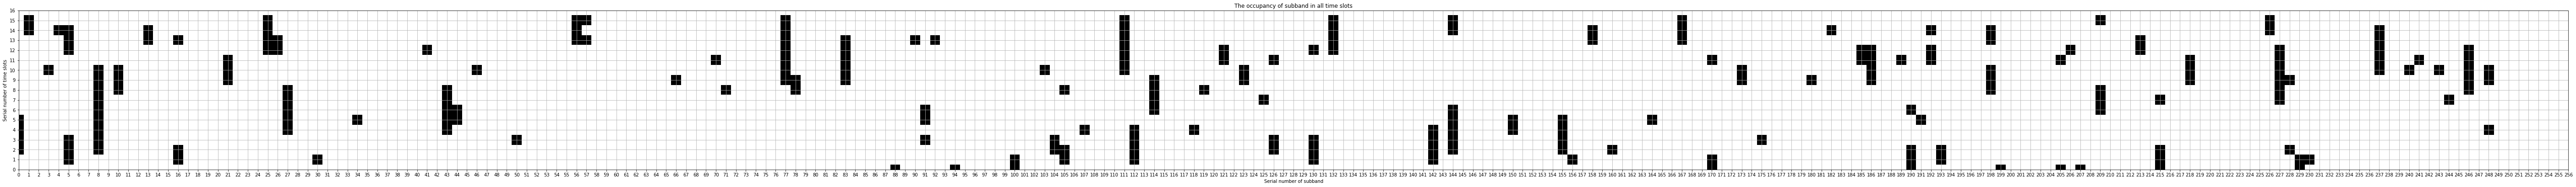

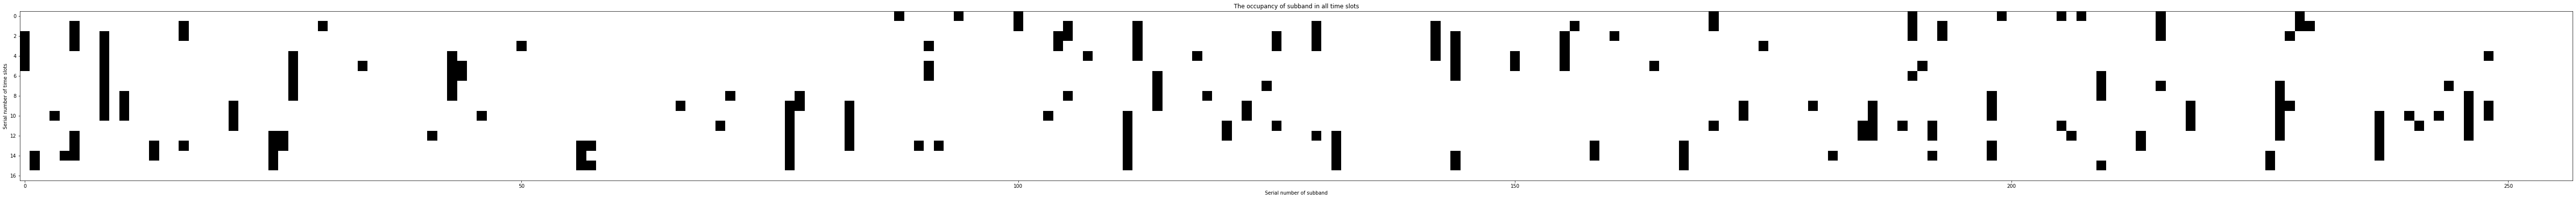



the figure of density over time


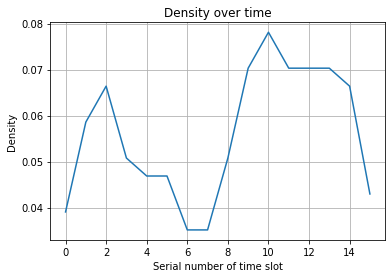



How do you interpret this density?
This density means the occupancy of the channel.


In [9]:
# task 1
def Subband_Occupied(fmin, B, Nuser, slot_f_axis, slot_N_X):
  subband_occupy = []
  for i in range(1, Nuser+1):
    center_f = fmin + i * B - B / 2
    subband_mask = np.where((slot_f_axis >= center_f - B/4) & (slot_f_axis <= center_f + B/4))[0]
    subband_occupy.append(1 if max(20 * np.log10(np.absolute(slot_N_X[subband_mask]))) > 10 else 0)
  
  return subband_occupy

# print(Subband_Occupied(fmin, B, Nuser, slot_f_axis, slot1_X))

# task 2
def Subband_Timeslot_Occupied(fmin, B, Nuser, Nslots, slot_f_axis, x, slot_dur):
  subband_timeslot_occupy = np.zeros((Nslots, Nuser))
  for N in range(Nslots):
    slot_N_x = x[N * slot_dur : (N + 1) * slot_dur]
    slot_N_X = np.fft.fftshift(np.fft.fft(slot_N_x))
    subband_timeslot_occupy[N, :] = Subband_Occupied(fmin, B, Nuser, slot_f_axis, slot_N_X)

  return subband_timeslot_occupy.T

# output the Nuser-by-Nslots matrix of subband occupancies for the signal x
print('the Nuser-by-Nslots matrix of subband occupancies for the signal x')
print(Subband_Timeslot_Occupied(fmin, B, Nuser, Nslots, slot_f_axis, x, slot_dur))
print('\n')

# task 3
def Subband_Timeslot_Visualization(subband_timeslot_occupy):
  Nuser, Nslots = np.shape(subband_timeslot_occupy)
  
  # first method to do visualizaiton
  from bokeh.models import Range1d, SingleIntervalTicker, LinearAxis
  top = []
  bottom = []
  left = []
  right = []
  for i in range(Nuser): 
    for j in range(Nslots):
      if subband_timeslot_occupy[i,j]:
        top.append(j+1)
        bottom.append(j)
        left.append(i)
        right.append(i+1)

  bpl.output_notebook()
  h = bpl.figure(plot_width=Nuser*22, plot_height=Nslots*22, title="The occupancy of subband in all time slots")
  h.xaxis.axis_label = 'Serial number of subband'
  h.yaxis.axis_label = 'Serial number of time slots'
  h.xaxis.ticker.desired_num_ticks = Nuser
  h.yaxis.ticker.desired_num_ticks = Nslots
  h.quad(left, right, top, bottom, color="#B3DE69")
  h.x_range=Range1d(0, Nuser)
  h.y_range=Range1d(0, Nslots)
  
  bpl.show(h)

  # second method to do visualizaiton
  import matplotlib.pyplot as plt
  # use the array to plot directly
  plt.imshow(subband_timeslot_occupy.T, cmap=plt.cm.binary) 
  plt.xlabel('Serial number of subband')
  plt.ylabel('Serial number of time slots')
  plt.title('The occupancy of subband in all time slots')
  plt.axis([0, Nuser, 0, Nslots])
  plt.gca().figure.set_size_inches(102.4, 6.4)
  plt.xticks(np.arange(0, Nuser+1, 1.0))
  plt.yticks(np.arange(0, Nslots+1, 1.0))
  # plt.gca().spines['bottom'].set_position(('data', -0.5))
  # plt.gca().spines['left'].set_position(('data', -0.5))
  plt.grid()
  plt.show()

  # third method to do visualizaiton
  import matplotlib.pyplot as plt
  from PIL import Image
  # create a white chess board
  img = Image.new("RGB", (Nuser+1, Nslots+1), 'white') # create a new 16x256 image
  pixels = img.load() # create the pixel map
  for i in range(Nuser):
    for j in range(Nslots):
      if subband_timeslot_occupy[i][j]:
        pixels[i,j] = (0,0,0) # make some block black
  plt.imshow(img)
  plt.xlabel('Serial number of subband')
  plt.ylabel('Serial number of time slots')
  plt.title('The occupancy of subband in all time slots')
  plt.gca().figure.set_size_inches(102.4, 6.4)
  plt.show()

# output an image that visualize your matrix
subband_timeslot_occupy = Subband_Timeslot_Occupied(fmin, B, Nuser, Nslots, slot_f_axis, x, slot_dur)
print('an image that visualize your matrix')
Subband_Timeslot_Visualization(subband_timeslot_occupy)
print('\n')

# task 4
def Density(subband_timeslot_occupy):
  Nuser, Nslots = np.shape(subband_timeslot_occupy)
  density = []
  for i in range(Nslots):
    # print(subband_timeslot_occupy.T[i,:])
    num = len(np.nonzero(subband_timeslot_occupy.T[i,:])[0])
    # print(num)
    density.append(num / Nuser)

  return density

print('the figure of density over time')
# output the figure of density over time
import matplotlib.pyplot as plt
density = Density(subband_timeslot_occupy)
plt.plot(density)
plt.xlabel('Serial number of time slot')
plt.ylabel('Density')
plt.title('Density over time')
plt.grid()
plt.show()
print('\n')

print('How do you interpret this density?')
print('This density means the occupancy of the channel.')


